In [249]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator

In [250]:
class IsingModel:
    def __init__(self, L, T):
        #parametros do modelo
        self.L = L
        self.T = T

        #array com os spins
        self.spins = np.ones((L,L))

        #arrays para guardar evoluções das variáveis
        self.energies= [self.calc_ener_total()]
        self.magnetizations= [L**2]

        #energia e magnetização total
        self.energy_total = self.calc_ener_total()
        self.magnet_total = np.sum(self.spins)

    def calc_ener_spin(self, i, j):
        #calcular a energia de um spin
        spin= self.spins[i,j]
        neighbours= (
        self.spins[(i+1)%self.L, j] + 
        self.spins[i, (j+1)%self.L] + 
        self.spins[(i-1)%self.L, j] + 
        self.spins[i, (j-1)%self.L]
        )
        energy=-spin*neighbours
        return energy
    
    def calc_ener_total( self ):
        energy=0
        for i in range(self.L):
            for j in range(self.L):
                energy+= -self.spins[i,j]*(self.spins[(i+1)%self.L,j]+ self.spins[i,(j+1)%self.L])
        return energy
    
    def calc_ener ( self ):
        energy=self.energy_total/self.L**2
        return energy
    
    def calc_mag( self ):
        mag = self.magnet_total
        return mag
    

    def iter_monte_carlo(self,n_iter):

        #calcular a energia do sistema inicialmente
        E = self.energies[0]
        Mag = self.magnetizations[0]

        #iterar com o método de Metropolis Hastings
        for _ in tqdm(range(n_iter), desc=f"L={self.L:6d},T={self.T:8f}"):
            #proposta: spin flip
            i = np.random.randint(0, self.L)
            j = np.random.randint(0, self.L)
            prop = self.spins.copy()
            prop[i, j] *= -1

            #calcular a probabilidade de a proposta ser aceite
            Delta_E = -2*self.calc_ener_spin(i, j)
            Delta_Mag = -2*self.spins[i,j]
            R = np.exp(-Delta_E/(self.T))
            
            u = np.random.uniform(0, 1)
            if R > u:
                self.spins = prop
                E += Delta_E
                Mag += Delta_Mag
                self.energy_total = E
                self.magnet_total = Mag

            self.energies.append(E)
            self.magnetizations.append(Mag)
    
    @property
    def energy(self):
        return np.array(self.energies)
    


## 1. Tempo de Termalização

**a)** Para cada combinação de L e T, corremos a simulação iter_monte_carlo, obtendo uma lista de como variou a energia a cada passo da iteração (ising.energies). A n-ésima entrada dessa lista (ising.energies[n-1]) dá a energia total do sistema após n iterações, pelo que a energia média, e, em função de n é ising.energies[n-1]/L^2.

L=   128,T=4.000000: 100%|██████████| 10000/10000 [00:00<00:00, 117259.56it/s]


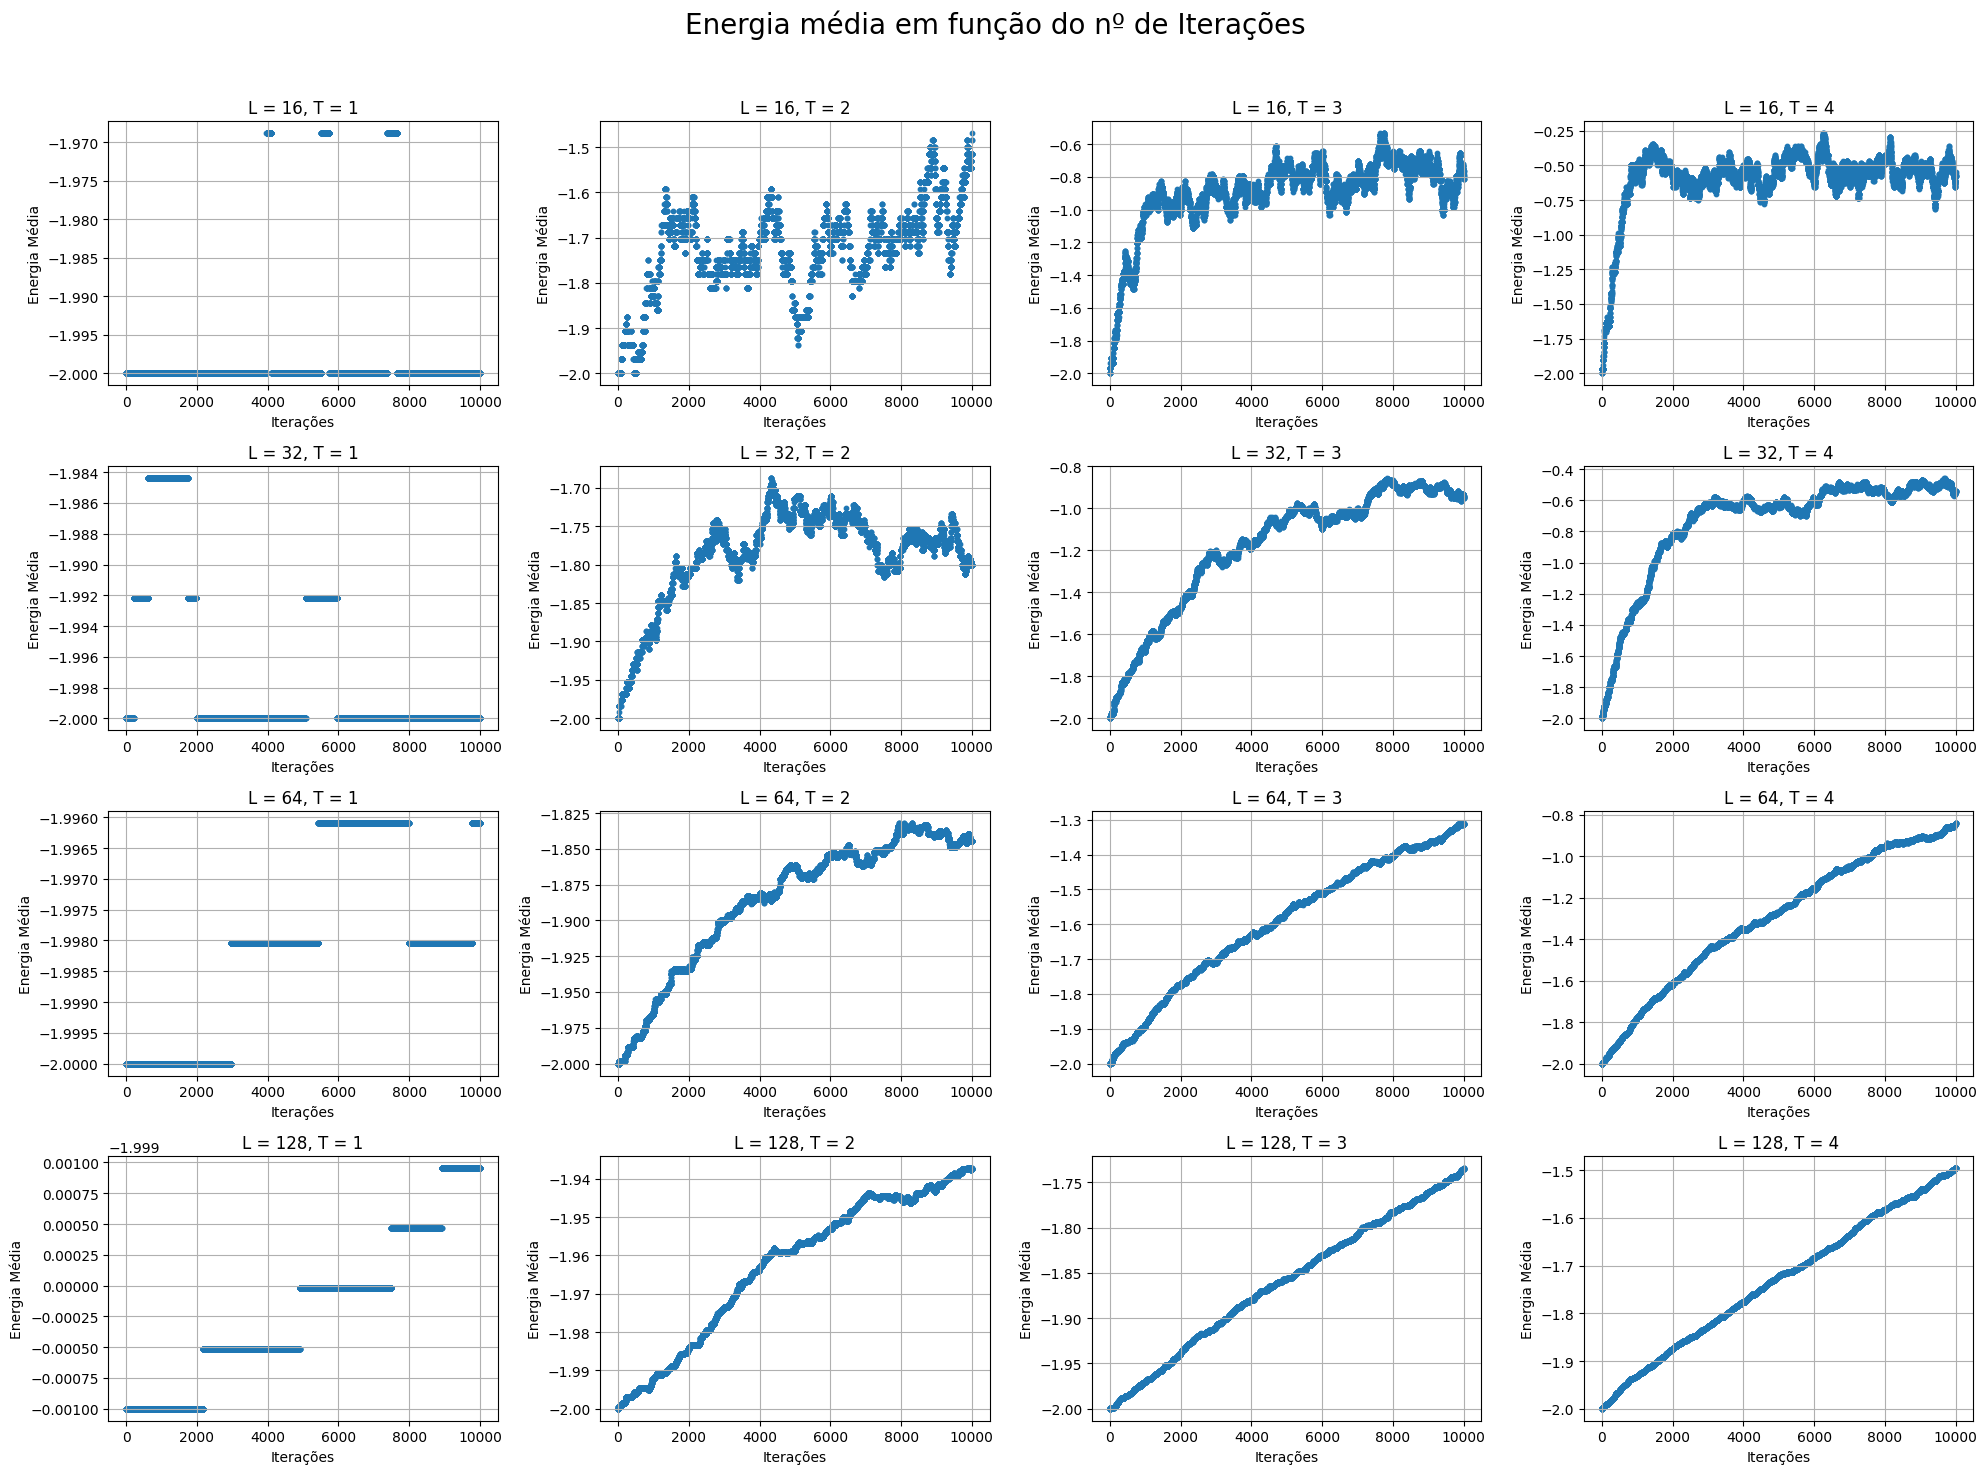

In [251]:
L_array = [16, 32, 64, 128]
T_array = [1, 2, 3, 4]
N = 10000 #limite superior para o número de iterações

fig, axes = plt.subplots(len(L_array), len(T_array), figsize=(20, 15))
fig.suptitle('Energia média em função do nº de Iterações', fontsize=20)

for i, L in enumerate(L_array):
    for j, T in enumerate(T_array):
        
        ising = IsingModel(L, T)
        ising.iter_monte_carlo(N)
        avg_ener = np.array(ising.energies[1:])/(L*L)

        ax = axes[i, j]
        ax.scatter(np.arange(1, N + 1), avg_ener, s=10)
        ax.set_title(f'L = {L}, T = {T}')
        ax.set_xlabel('Iterações')
        ax.set_ylabel('Energia Média')
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta o layout para dar espaço ao título
plt.show()

**b)** Com o módulo scipy.optimize, ajustámos aos dados anteriores uma função como a descrita no enunciado, determinando os parâmetros ef e tau, que são depois guardados no dicionário fit_results.

In [252]:
def ener_func(N, ef, tau):
    return ef + (e0 - ef) * np.exp(-N / tau)

def guesses_for_ef_and_tau(energy_vals, n_points):
    #o guess para ef será a média dos últimos 10% de valores
    ef_guess = np.mean(avg_ener[-int(0.1 * len(avg_ener)):])
    #o guess para tau será resultante de inverter a equação, usando ef_guess
    e0 = energy_vals[0]
    if e0 - ef_guess <= 0:
        return [ef_guess, len(energy_vals) / 10]
    
    indices = np.random.choice(np.arange(1, len(energy_vals)), size=n_points, replace=False)
    taus = [-i / np.log((energy_vals[i]-ef_guess) / (e0-ef_guess)) for i in indices 
            if energy_vals[i] > ef_guess and np.isfinite((energy_vals[i] - ef_guess) / (e0 - ef_guess))]
    
    tau_guess = np.mean(taus) if taus else len(energy_vals) / 10
    return [ef_guess, tau_guess]

# Dicionário para guardar os parâmetros de ajuste
fit_results = {}

for i, L in enumerate(L_array):
    for j, T in enumerate(T_array):
        
        ising = IsingModel(L, T)
        ising.iter_monte_carlo(N)
        N_values = np.arange(0, N + 1)
        avg_ener = np.array(ising.energies) / (L * L)
        e0 = avg_ener[0]

        # Chamada do ajuste com estimativas iniciais
        parameters, _ = curve_fit(ener_func, N_values, avg_ener, p0=guesses_for_ef_and_tau(avg_ener, 10))
        ef, tau = parameters

        # A chave (L,T) estará associada a um dicionário onde se guardam os valores ef e tau
        fit_results[(L, T)] = {'ef': ef, 'tau': tau}

print("Resultados do ajuste (ef e tau):\n")
for (L, T), params in fit_results.items():
    ef = params['ef']
    tau = params['tau']
    print(f"L = {L:3d}, T = {T:3d} --> ef = {ef:.5f}, tau = {tau:.2f}")

**c)** 

## 2. Determinação da Temperatura Crítica

In [254]:
T_values = np.arange(1, 4.1, 0.2)
N_measurements = 1000

# Iremos armazenar os resultados no seguinte dicionário:
results = {L: {'T': [], 'e_mean': [], 'e_std': [], 'm_mean': [], 'm_std': []} for L in L_array}

for L in L_array:
    for T in tqdm(T_values, desc=f"L={L}"):
        ising = IsingModel(L, T)
        ising.iter_monte_carlo(N_measurements)
        
        energies = np.array(ising.energies) / (L * L)  # energia média por spin
        magnetizations = np.array(ising.magnetizations) / (L * L)  # magnetização média por spin
        
        e_mean = np.mean(energies)
        e_std = np.std(energies)
        m_mean = np.mean(magnetizations)
        m_std = np.std(magnetizations)
        
        results[L]['T'].append(T)
        results[L]['e_mean'].append(e_mean)
        results[L]['e_std'].append(e_std)
        results[L]['m_mean'].append(m_mean)
        results[L]['m_std'].append(m_std)



## 3. Determinação da Energia Livre de Helmholtz, F

**a)** Para calcular a energia livre de Helmholtz, precisamos de saber a energia média e N, em que $N_{term} = 4\tau_{term}$. Neste caso, fixamos L em 128.

In [ ]:
#Placeholder para função tau verdadeira
def tau(L, T):
    return L + T

#Função calcula a energia livre de helmholtz para T e L determinados
def helmholtz(L, T, n):

    t_array = np.linspace(T, 10, n)
    integ_array = np.empty([]) #Array dos integrandos
    
    #O loop define o integrando para cada T (energ/temp^2)
    for t in t_array:
        #Correr simulação
        h_ising = IsingModel(L, t)
        h_ising.iter_monte_carlo(n)

        #Calcular termo integrando
        energy = h_ising.calc_ener()
        integ = energy/(t**2)
        np.append(integ_array, integ)
    
    N = 4 * tau(L, T)
    integral = cumulative_trapezoid(integ_array, t_array)

    return T*(integral - N*np.log(2))

#Definir L, n, e T inicial
L = 128
T_array = np.arange(0.1, 10, 0.1)
n = 100
F_array = np.empty([])


#Calcular as energias de helmholtz
for temp in T_array:
    F = helmholtz(L, temp, n)
    np.append(F_array, F)

#Plotar gráfico
plt.figure(figsize=(10, 5)) # tamanho da figura

plt.plot(T_array, F_array, label='Seno', color='blue') # plotando a função seno
plt.title('Gráfico de Seno') # título do gráfico
plt.xlabel('Eixo X') # rótulo do eixo x
plt.ylabel('Eixo Y') # rótulo do eixo y
plt.legend() # legenda
plt.grid() # grelha
plt.show() # mostrando o gráfico

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6
 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4
 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1 7.2
 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9 9.
 9.1 9.2 9.3 9.4 9.5 9.6 9.7 9.8 9.9]


L=   128,T=10.000000: 100%|██████████| 100/100 [00:00<00:00, 66166.65it/s]


IndexError: tuple index out of range

**b)** Para interpolar a função

In [ ]:
F_interpol = CubicSpline(T_array, F_array)
null_F = F_interpol.roots()

print(null_F)

plt.figure(figsize=(10, 5)) # tamanho da figura

plt.plot(T_array, F_interpol(T_array), label='Seno', color='blue') # plotando a função seno
plt.title('Gráfico de Seno') # título do gráfico
plt.xlabel('Eixo X') # rótulo do eixo x
plt.ylabel('Eixo Y') # rótulo do eixo y
plt.legend() # legenda
plt.grid() # grelha
plt.show() # mostrando o gráfico

ZeroDivisionError: integer modulo by zero

**c)**

In [ ]:
deriv2 = F_interpol.derivative[2]

plt.figure(figsize=(10, 5)) # tamanho da figura

plt.plot(T_array, deriv2(T_array), label='Seno', color='blue') # plotando a função seno
plt.title('Gráfico de Seno') # título do gráfico
plt.xlabel('Eixo X') # rótulo do eixo x
plt.ylabel('Eixo Y') # rótulo do eixo y
plt.legend() # legenda
plt.grid() # grelha
plt.show() # mostrando o gráfico